## **IMPORT LIBRARY**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


## **READ DATA**

In [2]:
data = pd.read_csv(r'D:\KULIAH\SEMESTER 6\SAINS DATA PADA INDUSTRI\studyCase3-dynamicPricing\flight_data.csv')
data

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,15/01/2023,16/01/2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,15/01/2023,16/01/2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"
...,...,...,...,...,...,...,...,...
452083,15/01/2023,06/03/2023,Vistara \nUK-926\nBUSINESS,06:45\nAhmedabad,19:50\nChennai,13h 05m,1-stop,"65,028"
452084,15/01/2023,06/03/2023,Vistara \nUK-918\nBUSINESS,05:05\nAhmedabad,16:20\nChennai,11h 15m,1-stop,"69,254"
452085,15/01/2023,06/03/2023,Vistara \nUK-918\nBUSINESS,05:05\nAhmedabad,16:20\nChennai,11h 15m,1-stop,"69,254"
452086,15/01/2023,06/03/2023,Vistara \nUK-946\nBUSINESS,08:40\nAhmedabad,19:50\nChennai,11h 10m,1-stop,"72,980"


## **Exploratory Data Analyst**

In [3]:
clean_df = data.copy()
clean_df['Date of Booking'] = pd.to_datetime(clean_df['Date of Booking'], format='%d/%m/%Y')
clean_df['Date of Journey'] = pd.to_datetime(clean_df['Date of Journey'], format='%d/%m/%Y')


# -----------------------------------------------------------------------------
# Split the column into 3 parts
split_cols = clean_df['Airline-Class'].str.split('\n', expand=True)
split_cols.columns = ['Airline', 'flightNumber', 'Class']
# Insert the new columns right after 'Airline-Class'
col_index = clean_df.columns.get_loc('Airline-Class') + 1
for i, col_name in enumerate(split_cols.columns):
    clean_df.insert(col_index + i, col_name, split_cols[col_name].str.strip())
clean_df.drop('Airline-Class', axis=1, inplace=True)
# Remove any extra spaces
clean_df['Airline'] = clean_df['Airline'].str.strip()
clean_df['flightNumber'] = clean_df['flightNumber'].str.strip()
clean_df['Class'] = clean_df['Class'].str.strip()
clean_df.drop(['flightNumber'], axis=1, inplace=True)

# -----------------------------------------------------------------------------
# --- Departure Time ---
# Contoh: "20:00\nDelhi"
clean_df[['departureTime', 'departureCity']] = clean_df['Departure Time'].str.split('\n', expand=True)
clean_df['departureTime'] = clean_df['departureTime'].str.strip()
clean_df['departureCity'] = clean_df['departureCity'].str.strip()
clean_df.drop('Departure Time', axis=1, inplace=True)

# --- Arrival Time ---
# Contoh: "22:05\nMumbai"
clean_df[['arrivalTime', 'arrivalCity']] = clean_df['Arrival Time'].str.split('\n', expand=True)
clean_df['arrivalTime'] = clean_df['arrivalTime'].str.strip()
clean_df['arrivalCity'] = clean_df['arrivalCity'].str.strip()
clean_df.drop('Arrival Time', axis=1, inplace=True)
# ARRIVAL AND DEPARTURE TIME
def map_time_period(time_str):
    if pd.isna(time_str):
        return None
    hour = int(time_str.split(":")[0])
    if 0 <= hour < 6:
        return "Late Night"
    elif 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    else:
        return "Evening"

# Terapkan ke kolom
clean_df['arrivalTime'] = clean_df['arrivalTime'].apply(map_time_period)
clean_df['departureTime'] = clean_df['departureTime'].apply(map_time_period)

# --- Duration ---
# Contoh: "2h 5m", "1h", "45m"
def duration_to_minutes(text):
    hours = minutes = 0
    h = re.search(r'(\d+)h', text)
    m = re.search(r'(\d+)m', text)
    if h: hours = int(h.group(1))
    if m: minutes = int(m.group(1))
    return hours * 60 + minutes

clean_df['durationMinutes'] = clean_df['Duration'].apply(duration_to_minutes)
clean_df.drop('Duration', axis=1, inplace=True)

# --- Total Stops ---
# Contoh: "1 stop via Pune" atau "non-stop"
def extract_stops(text):
    if pd.isna(text):
        return None  # Handle NaN
    text = str(text).lower()
    if "non-stop" in text:
        return 0
    match = re.search(r'(\d+)', text)
    return int(match.group(1)) if match else None

# Terapkan ke dataframe
clean_df['totalStop'] = clean_df['Total Stops'].apply(extract_stops)
clean_df.drop('Total Stops', axis=1, inplace=True)


# --- Price ---
# Contoh: "5,335"
clean_df['Price'] = clean_df['Price'].str.replace(',', '').astype(int)
clean_df = clean_df[[col for col in clean_df.columns if col != 'Price'] + ['Price']]

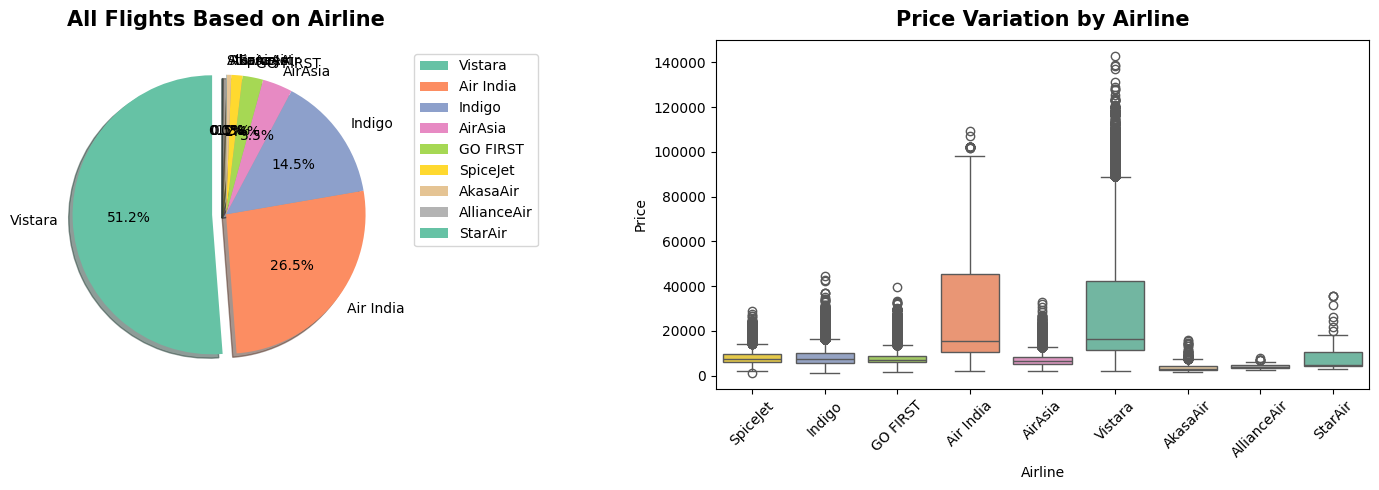

In [4]:
# Hitung frekuensi maskapai
flight_airline = clean_df['Airline'].value_counts()

# Generate palette colors sesuai urutan Airline
airlines = flight_airline.index.tolist()
colors = sns.color_palette('Set2', len(airlines))
color_dict = dict(zip(airlines, colors))

# Siapkan subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# ==== PIE CHART ====
axs[0].set_title('All Flights Based on Airline', fontsize=15, weight='bold', pad=10)

# Buat explode dinamis: highlight maskapai dengan frekuensi terbanyak
explode = [0.1 if i == 0 else 0 for i in range(len(flight_airline))]

axs[0].pie(
    flight_airline,
    labels=flight_airline.index,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode,
    startangle=90,
    colors=colors  # Apply colors here
)
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1)

# ==== BOX PLOT ====
axs[1].set_title('Price Variation by Airline', fontsize=15, weight='bold', pad=10)
sns.boxplot(
    x='Airline',
    y='Price',
    data=clean_df,
    ax=axs[1],
    hue='Airline',
    palette=color_dict,  # Ensure same color mapping as pie
    legend=False
)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

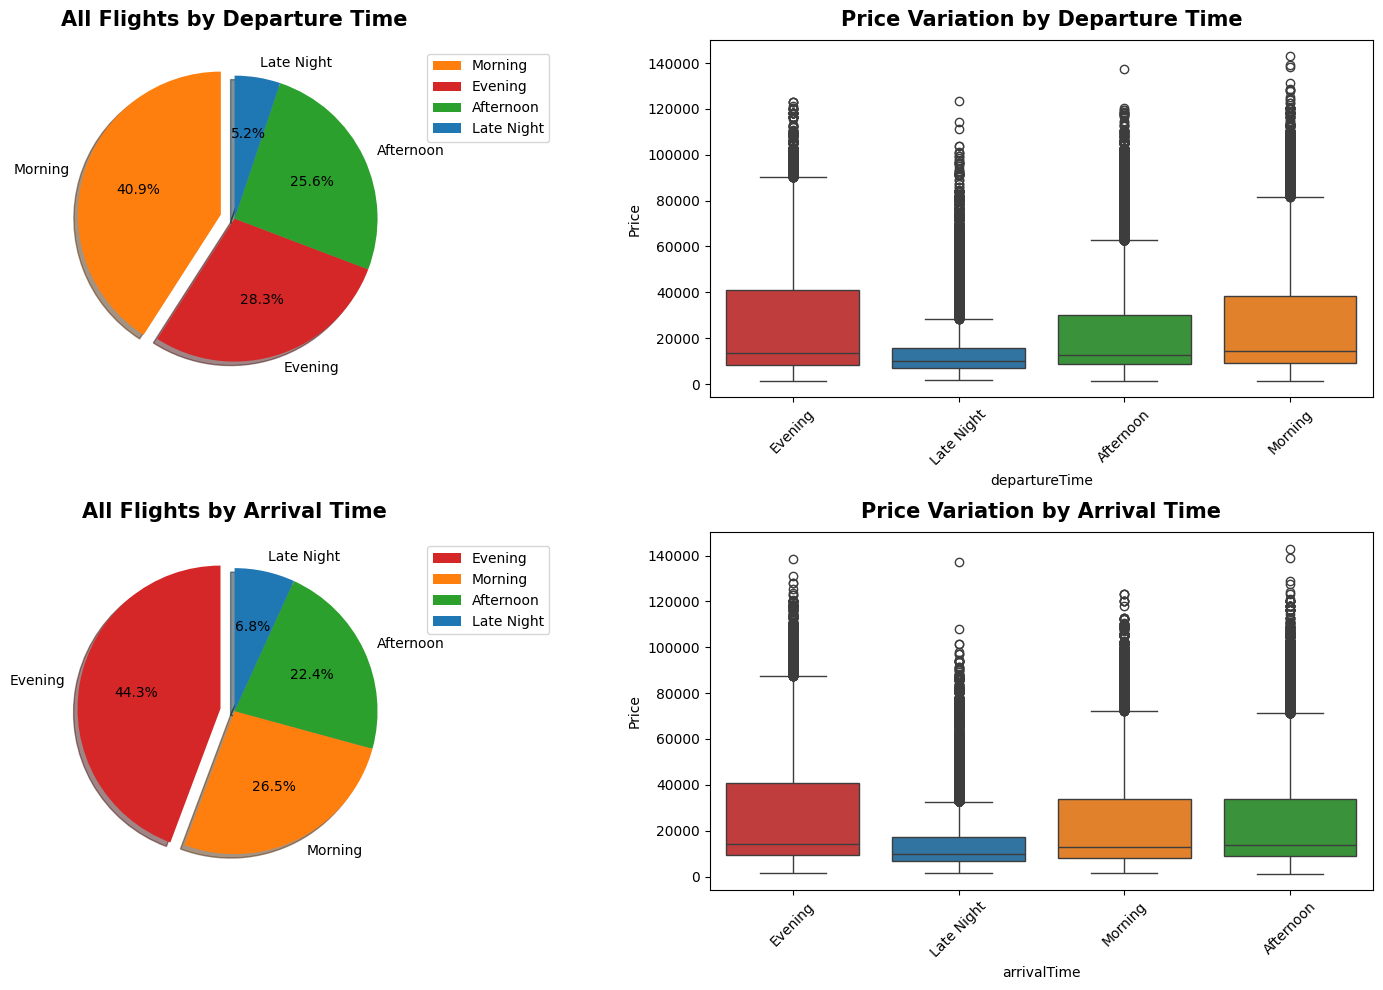

In [5]:
# Pastikan kolomnya ada
flight_depart_time = clean_df['departureTime'].value_counts()
flight_arr_time = clean_df['arrivalTime'].value_counts()

# Semua kategori waktu
time_periods = ['Late Night', 'Morning', 'Afternoon', 'Evening']

# Warna tetap untuk masing-masing waktu
colors = {
    'Late Night': '#1f77b4',
    'Morning': '#ff7f0e',
    'Afternoon': '#2ca02c',
    'Evening': '#d62728'
}

# Ambil warna sesuai urutan kategori yang muncul
depart_colors = [colors[period] for period in flight_depart_time.index]
arr_colors = [colors[period] for period in flight_arr_time.index]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# PIE Chart - Departure Time
axs[0, 0].set_title('All Flights by Departure Time', fontsize=15, weight='bold', pad=10)
explode_depart = [0.1 if i == 0 else 0 for i in range(len(flight_depart_time))]
axs[0, 0].pie(
    flight_depart_time,
    labels=flight_depart_time.index,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode_depart,
    startangle=90,
    colors=depart_colors
)
axs[0, 0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1)

# Boxplot - Departure Time
axs[0, 1].set_title('Price Variation by Departure Time', fontsize=15, weight='bold', pad=10)
sns.boxplot(x='departureTime', y='Price', data=clean_df, ax=axs[0, 1], hue='departureTime', palette=colors, legend=False)
axs[0, 1].tick_params(axis='x', rotation=45)

# PIE Chart - Arrival Time
axs[1, 0].set_title('All Flights by Arrival Time', fontsize=15, weight='bold', pad=10)
explode_arrival = [0.1 if i == 0 else 0 for i in range(len(flight_arr_time))]
axs[1, 0].pie(
    flight_arr_time,
    labels=flight_arr_time.index,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode_arrival,
    startangle=90,
    colors=arr_colors
)
axs[1, 0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1)

# Boxplot - Arrival Time
axs[1, 1].set_title('Price Variation by Arrival Time', fontsize=15, weight='bold', pad=10)
sns.boxplot(x='arrivalTime', y='Price', data=clean_df, ax=axs[1, 1], hue='arrivalTime', palette=colors, legend=False)
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


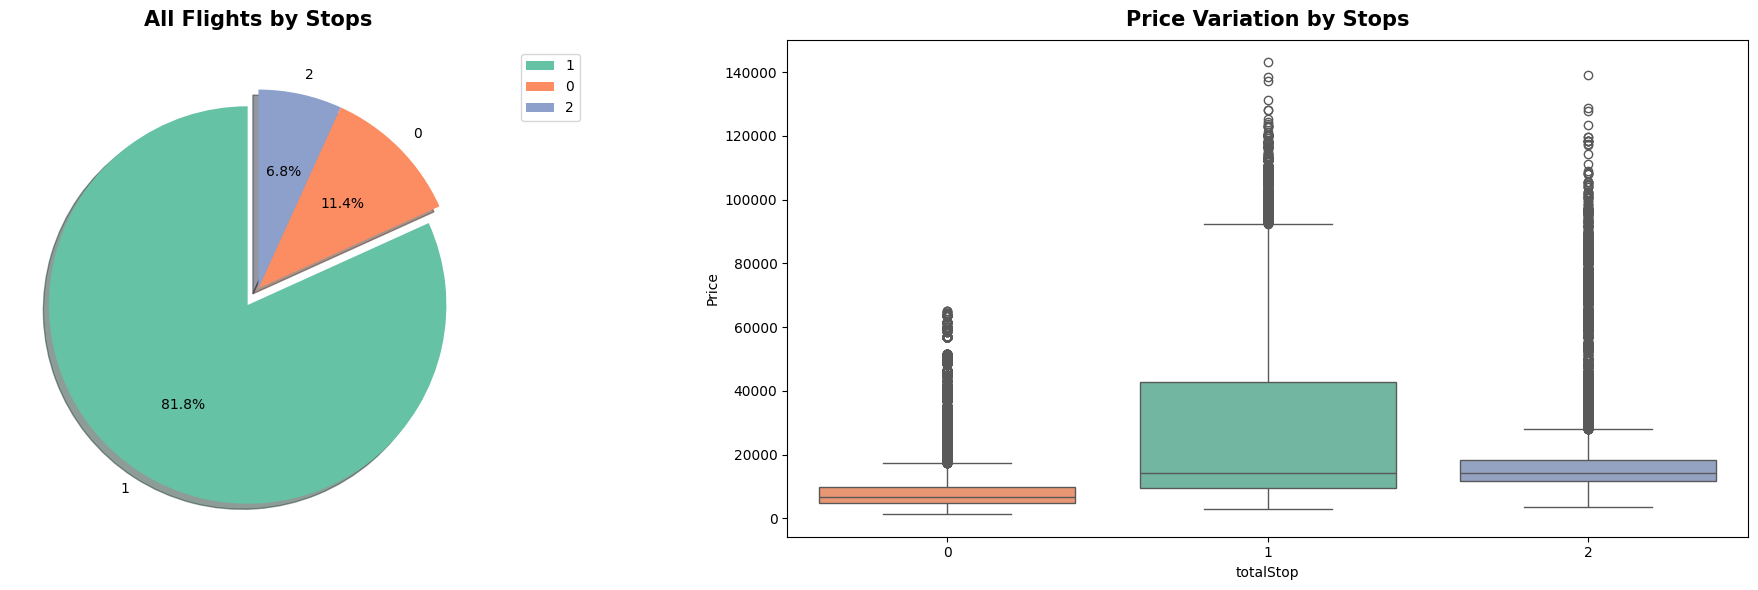

In [6]:
# Hitung jumlah penerbangan berdasarkan jumlah stop
flight_stops = clean_df['totalStop'].value_counts()

# Buat daftar stops dan warna
stops_list = flight_stops.index.tolist()
colors = sns.color_palette('Set2', len(stops_list))
color_dict = dict(zip(stops_list, colors))

# Buat subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# ==== PIE CHART ====
axs[0].set_title('All Flights by Stops', fontsize=15, weight='bold', pad=10)

# Buat explode dinamis, misal highlight kategori terbanyak
explode = [0.1 if i == 0 else 0 for i in range(len(flight_stops))]

axs[0].pie(
    flight_stops,
    labels=stops_list,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode,
    startangle=90,
    colors=[color_dict[stop] for stop in stops_list]
)

axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1)

# ==== BOX PLOT ====
axs[1].set_title('Price Variation by Stops', fontsize=15, weight='bold', pad=10)

sns.boxplot(
    x='totalStop',
    y='Price',
    data=clean_df,
    hue='totalStop',
    palette=color_dict,
    ax=axs[1],
    legend=False
)

axs[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


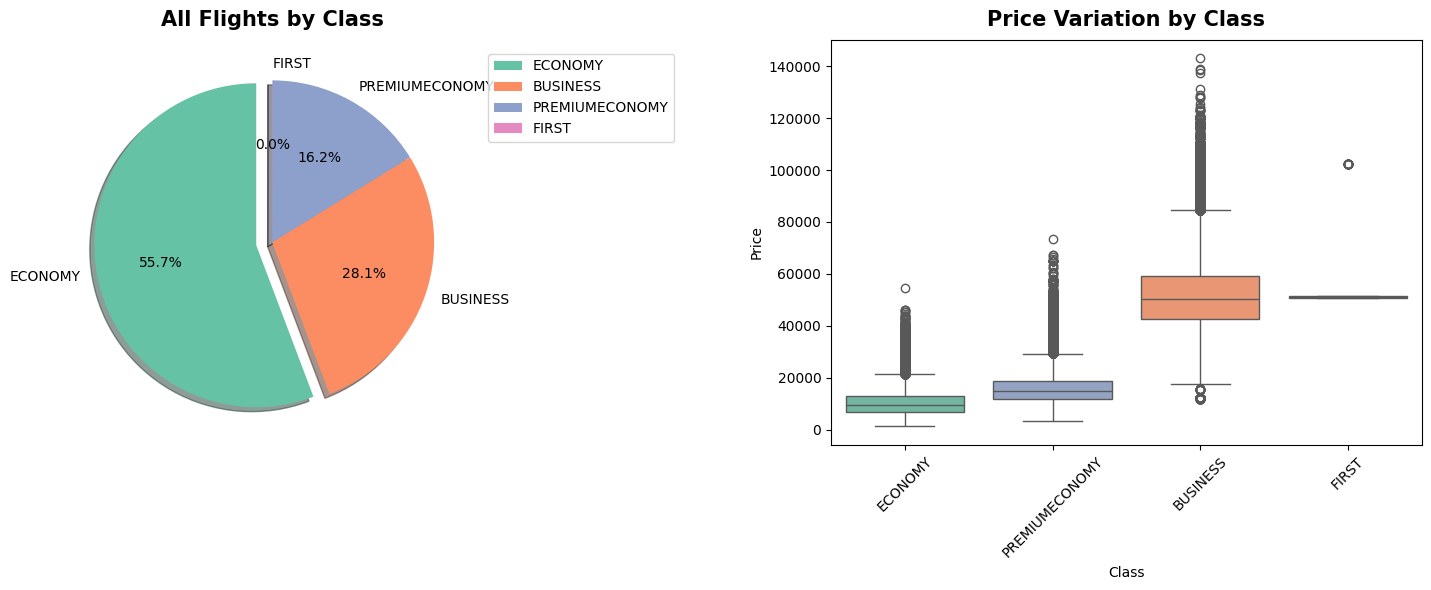

In [7]:
# Hitung frekuensi berdasarkan kelas penerbangan
flight_class = clean_df['Class'].value_counts()

# Ambil daftar kelas dalam urutan value_counts
class_list = flight_class.index.tolist()

# Generate warna yang konsisten
colors = sns.color_palette('Set2', len(class_list))
color_dict = dict(zip(class_list, colors))

# Buat subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# ==== PIE CHART ====
axs[0].set_title('All Flights by Class', fontsize=15, weight='bold', pad=10)

# Buat explode dinamis: highlight kelas dengan frekuensi terbanyak
explode = [0.1 if i == 0 else 0 for i in range(len(flight_class))]

axs[0].pie(
    flight_class,
    labels=class_list,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode,
    startangle=90,
    colors=[color_dict[cls] for cls in class_list]
)

axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1)

# ==== BOX PLOT ====
axs[1].set_title('Price Variation by Class', fontsize=15, weight='bold', pad=10)

sns.boxplot(
    x='Class',
    y='Price',
    data=clean_df,
    hue='Class',
    palette=color_dict,
    ax=axs[1],
    legend=False
)

axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


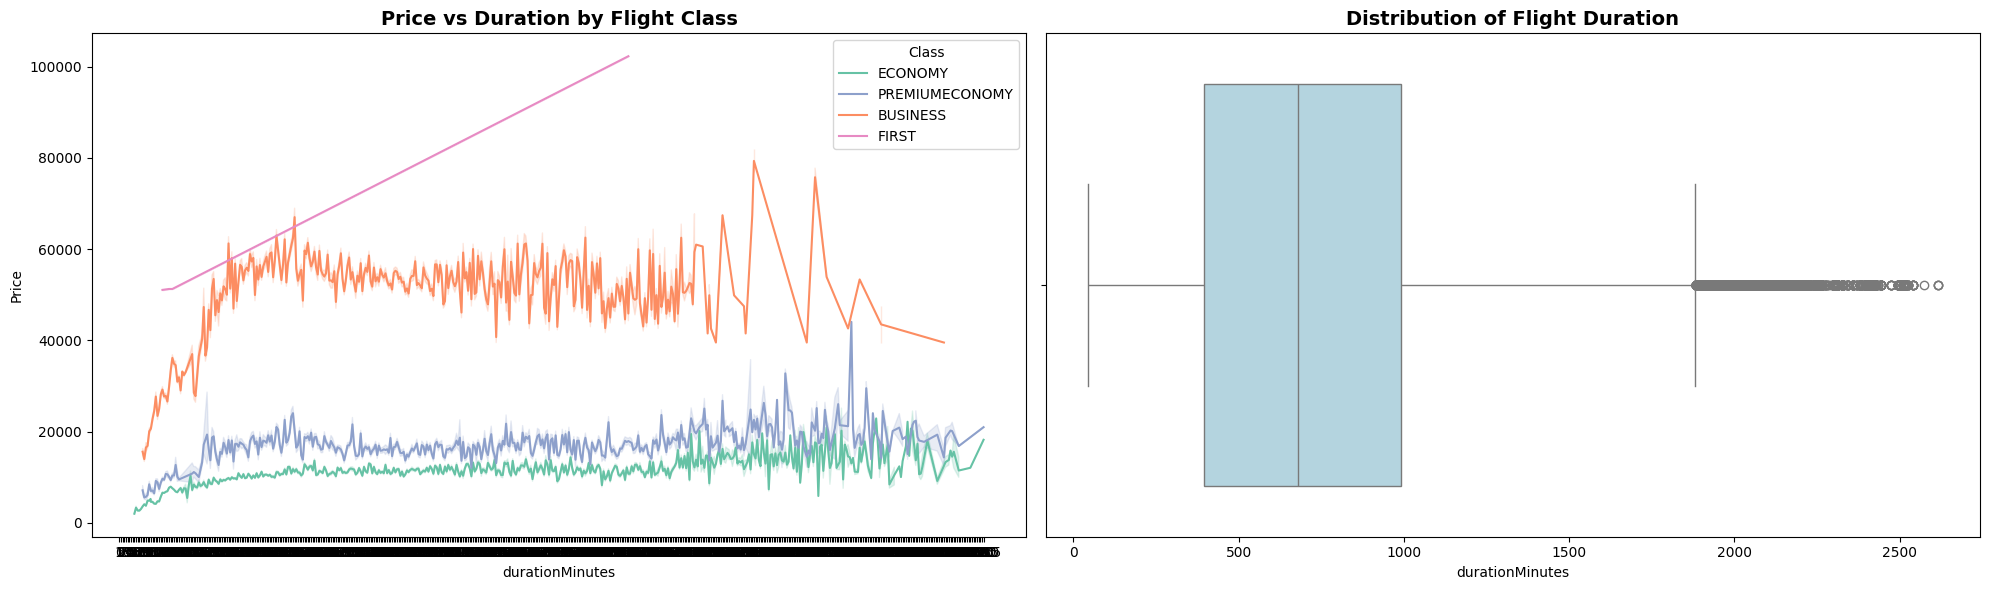

In [8]:
# Ambil kelas penerbangan unik dan generate palette
# class_list = df['flight_class'].unique()
colors = sns.color_palette('Set2', len(class_list))
color_dict = dict(zip(class_list, colors))

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# LINE PLOT: Duration vs Price by flight_class
sns.lineplot(
    x='durationMinutes',
    y='Price',
    data=clean_df,
    ax=axs[0],
    hue='Class',
    palette=color_dict
)
axs[0].set_xticks(np.arange(0, clean_df['durationMinutes'].max()+1, 5))
axs[0].set_title('Price vs Duration by Flight Class', fontsize=14, weight='bold')

# BOX PLOT: Distribution of Duration
sns.boxplot(
    x='durationMinutes',
    data=clean_df,
    ax=axs[1],
    color='lightblue'
)
axs[1].set_title('Distribution of Flight Duration', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

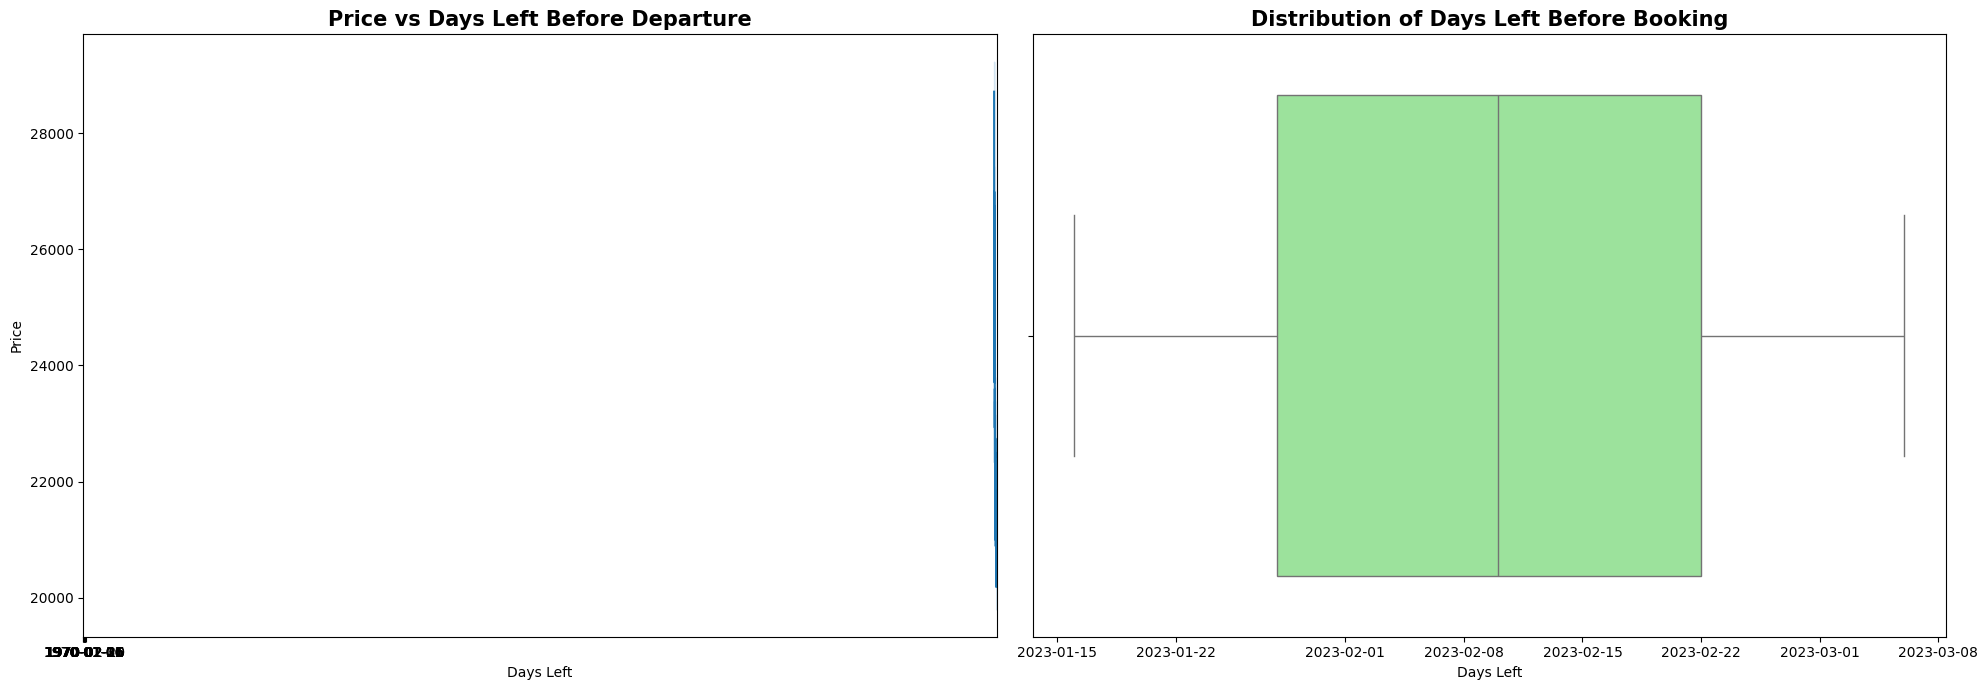

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1
sns.lineplot(x='Date of Journey', y='Price', data=clean_df, ax=axs[0], color='tab:blue')
axs[0].set_xticks(np.arange(0, 51, 5))
axs[0].set_title('Price vs Days Left Before Departure', fontsize=15, weight='bold')
axs[0].set_xlabel('Days Left')
axs[0].set_ylabel('Price')

# Plot 2
sns.boxplot(x='Date of Journey', data=clean_df, ax=axs[1], color='lightgreen')
axs[1].set_title('Distribution of Days Left Before Booking', fontsize=15, weight='bold')
axs[1].set_xlabel('Days Left')

plt.tight_layout()
plt.show()

In [10]:
print("INFORMASI DATA")
print(data.info())
print("=="*50)
print("DESKRIPSI DATA")
print(data.describe())  
print("=="*50)
print("DATA KOSONG")
print(data.isnull().sum())
print("=="*50)
print("DATA DUPLIKAT")
print(data.duplicated().sum())

INFORMASI DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date of Booking  452088 non-null  object
 1   Date of Journey  452088 non-null  object
 2   Airline-Class    452088 non-null  object
 3   Departure Time   452088 non-null  object
 4   Arrival Time     452088 non-null  object
 5   Duration         452088 non-null  object
 6   Total Stops      452088 non-null  object
 7   Price            452088 non-null  object
dtypes: object(8)
memory usage: 27.6+ MB
None
DESKRIPSI DATA
       Date of Booking Date of Journey              Airline-Class  \
count           452088          452088                     452088   
unique               1              50                       1836   
top         15/01/2023      31/01/2023  Vistara \nUK-918\nECONOMY   
freq            452088            9824                       2270   

        

# **Membersihkan Data**
- Menghapus spasi, karakter aneh, dan baris kosong
- Menghapus duplikat
- Mengonversi harga ke format numerik

In [11]:
duplicated_data = data[data.duplicated(keep="last")]
duplicated_data

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
19210,15/01/2023,16/01/2023,Vistara \nUK-627\nECONOMY,13:20\nDelhi,19:15\nBangalore,29h 55m,2+-stop,"11,117"
19320,15/01/2023,16/01/2023,Vistara \nUK-627\nPREMIUMECONOMY,13:20\nDelhi,20:55\nBangalore,31h 35m,2+-stop,"20,084"
19322,15/01/2023,16/01/2023,Vistara \nUK-627\nPREMIUMECONOMY,13:20\nDelhi,22:50\nBangalore,33h 30m,2+-stop,"20,084"
19632,15/01/2023,17/01/2023,Vistara \nUK-929\nECONOMY,21:20\nDelhi,19:15\nBangalore,21h 55m,2+-stop,"15,473"
19669,15/01/2023,17/01/2023,Vistara \nUK-627\nPREMIUMECONOMY,13:20\nDelhi,19:15\nBangalore,29h 55m,2+-stop,"15,196"
...,...,...,...,...,...,...,...,...
451998,15/01/2023,06/03/2023,Air India \nAI-482\nECONOMY,14:40\nAhmedabad,01:05\nChennai,10h 25m,1-stop,"11,646"
452009,15/01/2023,06/03/2023,Vistara \nUK-918\nECONOMY,05:05\nAhmedabad,16:20\nChennai,11h 15m,1-stop,"15,856"
452010,15/01/2023,06/03/2023,Vistara \nUK-918\nECONOMY,05:05\nAhmedabad,16:20\nChennai,11h 15m,1-stop,"15,856"
452084,15/01/2023,06/03/2023,Vistara \nUK-918\nBUSINESS,05:05\nAhmedabad,16:20\nChennai,11h 15m,1-stop,"69,254"


In [12]:
# Hilangkan leading/trailing whitespace dan karakter newline pada semua kolom bertipe string
data = data.applymap(lambda x: str(x).strip().replace('\n', ' ') if isinstance(x, str) else x)

# Hilangkan baris duplikat (berdasarkan seluruh kolom)
data = data.drop_duplicates(keep='last')

# Jika ada kolom harga dengan koma, ubah ke float
data['Price'] = data['Price'].astype(str).str.replace(',', '').astype(float)

# Membersihkan karakter '\t' (tab) dan spasi berlebih pada kolom 'Total Stops'
data['Total Stops'] = data['Total Stops'].astype(str).str.replace('\t', '', regex=True).str.strip()

data.reset_index(drop=True, inplace=True)
data.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet SG-8169 ECONOMY,20:00 Delhi,22:05 Mumbai,02h 05m,non-stop,5335.0
1,15/01/2023,16/01/2023,Indigo 6E-2519 ECONOMY,23:00 Delhi,01:20 Mumbai,02h 20m,non-stop,5899.0
2,15/01/2023,16/01/2023,GO FIRST G8- 354 ECONOMY,22:30 Delhi,00:40 Mumbai,02h 10m,non-stop,5801.0
3,15/01/2023,16/01/2023,SpiceJet SG-8709 ECONOMY,18:50 Delhi,20:55 Mumbai,02h 05m,non-stop,5794.0
4,15/01/2023,16/01/2023,Air India AI-805 ECONOMY,20:00 Delhi,22:10 Mumbai,02h 10m,non-stop,5955.0


In [13]:
data['Departure Time'].value_counts()

Departure Time
20:30 Hyderabad    5766
20:30 Chennai      5173
08:25 Ahmedabad    5117
05:05 Ahmedabad    4912
10:15 Kolkata      4437
                   ... 
10:20 Ahmedabad       1
04:30 Delhi           1
19:55 Kolkata         1
07:50 Delhi           1
09:00 Chennai         1
Name: count, Length: 1011, dtype: int64

In [14]:
data['Arrival Time'].value_counts()

Arrival Time
19:50 Chennai      4822
23:55 Ahmedabad    4382
19:35 Kolkata      4369
19:45 Ahmedabad    4254
18:05 Kolkata      4171
                   ... 
21:45 Mumbai          1
17:55 Ahmedabad       1
17:40 Delhi           1
14:40 Bangalore       1
09:35 Ahmedabad       1
Name: count, Length: 1050, dtype: int64

In [15]:
print("INFORMASI DATA")
print(data.info())
print("=="*50)
print("DESKRIPSI DATA")
print(data.describe())  
print("=="*50)
print("DATA KOSONG")
print(data.isnull().sum())
print("=="*50)
print("DATA DUPLIKAT")
print(data.duplicated().sum())

INFORMASI DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445366 entries, 0 to 445365
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date of Booking  445366 non-null  object 
 1   Date of Journey  445366 non-null  object 
 2   Airline-Class    445366 non-null  object 
 3   Departure Time   445366 non-null  object 
 4   Arrival Time     445366 non-null  object 
 5   Duration         445366 non-null  object 
 6   Total Stops      445366 non-null  object 
 7   Price            445366 non-null  float64
dtypes: float64(1), object(7)
memory usage: 27.2+ MB
None
DESKRIPSI DATA
               Price
count  445366.000000
mean    22919.747165
std     20394.214040
min      1307.000000
25%      8712.000000
50%     13362.000000
75%     36980.000000
max    143019.000000
DATA KOSONG
Date of Booking    0
Date of Journey    0
Airline-Class      0
Departure Time     0
Arrival Time       0
Duration           0
Total

### Langkah Preprocessing Kolom Kategorikal dan Waktu
- Airline & Class: lakukan encoding (Label/One-Hot Encoding)
- Departure Time & Arrival Time: ubah ke datetime, ekstrak jam/menit/waktu
- Duration: konversi ke total menit
- Total Stop: ubah ke numerik (misal, 'non-stop'=0, '1 stop'=1, dst)

In [16]:
# Preprocessing kolom Airline-Class, Departure Time, Arrival Time, Duration, dan Total Stops untuk clustering dan time series

# 1. Pisahkan Airline-Class menjadi Airline, Flight_Code, dan Class
split_cols = data['Airline-Class'].str.extract(r'([A-Za-z ]+)\s+([A-ZaZ0-9-]+)\s+([A-Za-z]+)')
split_cols.columns = ['Airline', 'Flight Code', 'Class']
data = pd.concat([data, split_cols], axis=1)

le_flight_code = LabelEncoder()
data['Flight_Code_Encoded'] = le_flight_code.fit_transform(data['Flight Code'].astype(str))

# 2. Label Encoding untuk Airline dan Class
le_airline = LabelEncoder()
le_class = LabelEncoder()
data['Airline'] = le_airline.fit_transform(data['Airline'].astype(str))
data['Class'] = le_class.fit_transform(data['Class'].astype(str))
data = data.drop(columns=['Airline-Class'])

# # 3. Ubah format waktu ke datetime
# Format tanggal
data['Date of Booking'] = pd.to_datetime(data['Date of Booking'], dayfirst=True)
data['Date of Journey'] = pd.to_datetime(data['Date of Journey'], dayfirst=True)

# 4. Duration: konversi ke total menit
def duration_to_minutes(x):
    if pd.isnull(x):
        return np.nan
    h, m = 0, 0
    if 'h' in x:
        h = int(x.split('h')[0].strip())
        x = x.split('h')[1]
    if 'm' in x:
        m = int(x.split('m')[0].strip())
    return h*60 + m
data['Duration'] = data['Duration'].apply(duration_to_minutes)

# 5. Total Stops: ekstrak jumlah stop dari string
# Sudah dibersihkan dari tab dan spasi sebelumnya
def extract_stops(x):
    x = str(x).lower()
    if 'non' in x:
        return 0
    elif '1-stop' in x:
        return 1
    elif '2' in x:
        return 2
    elif '3' in x:
        return 3
    else:
        return np.nan
data['Total Stops'] = data['Total Stops'].apply(extract_stops)

data.head()

,Date of Booking,Date of Journey,Departure Time,Arrival Time,Duration,Total Stops,Price,Airline,Flight Code,Class,Flight_Code_Encoded
0,2023-01-15,2023-01-16,20:00 Delhi,22:05 Mumbai,125,0,5335.0,7,SG-8169,1,836
1,2023-01-15,2023-01-16,23:00 Delhi,01:20 Mumbai,140,0,5899.0,6,6E-2519,1,110
2,2023-01-15,2023-01-16,22:30 Delhi,00:40 Mumbai,130,0,5801.0,4,FIRST,3,637
3,2023-01-15,2023-01-16,18:50 Delhi,20:55 Mumbai,125,0,5794.0,7,SG-8709,1,850
4,2023-01-15,2023-01-16,20:00 Delhi,22:10 Mumbai,130,0,5955.0,0,AI-805,1,606


## Process data Departure Time dan Arrival Time


In [17]:
# Ekstrak waktu dan tempat dari kolom Departure Time dan Arrival Time, lalu encode tempat, dan drop kolom asli

def split_time_place(x):
    if pd.isnull(x):
        return pd.Series([np.nan, np.nan])
    match = re.match(r'(\d{1,2}:\d{2})\s*(.*)', str(x).strip())
    if match:
        time_part = match.group(1)
        place_part = match.group(2).strip() if match.group(2) else np.nan
        return pd.Series([time_part, place_part])
    else:
        return pd.Series([np.nan, np.nan])

# Ekstrak waktu dan tempat keberangkatan
split_departure = data['Departure Time'].apply(split_time_place)
split_departure.columns = ['Departure_Time', 'Departure_Place']
data = pd.concat([data, split_departure], axis=1)

# Ekstrak waktu dan tempat kedatangan
split_arrival = data['Arrival Time'].apply(split_time_place)
split_arrival.columns = ['Arrival_Time', 'Arrival_Place']
data = pd.concat([data, split_arrival], axis=1)

# Konversi waktu ke menit
def time_to_minutes(x):
    try:
        if pd.isnull(x):
            return np.nan
        jam, menit = map(int, str(x).split(':'))
        return jam * 60 + menit
    except:
        return np.nan

data['Departure_Time'] = data['Departure_Time'].apply(time_to_minutes)
data['Arrival_Time'] = data['Arrival_Time'].apply(time_to_minutes)

# Label Encoding untuk tempat keberangkatan dan kedatangan
le_departure_place = LabelEncoder()
le_arrival_place = LabelEncoder()
data['Departure_Place_Encoded'] = le_departure_place.fit_transform(data['Departure_Place'].astype(str))
data['Arrival_Place_Encoded'] = le_arrival_place.fit_transform(data['Arrival_Place'].astype(str))

# Drop kolom Departure Time dan Arrival Time yang asli
data = data.drop(columns=['Departure Time', 'Arrival Time'])

data[['Departure_Time', 'Departure_Place', 'Departure_Place_Encoded', 'Arrival_Time', 'Arrival_Place', 'Arrival_Place_Encoded']].head()

,Departure_Time,Departure_Place,Departure_Place_Encoded,Arrival_Time,Arrival_Place,Arrival_Place_Encoded
0,1200,Delhi,3,1325,Mumbai,6
1,1380,Delhi,3,80,Mumbai,6
2,1350,Delhi,3,40,Mumbai,6
3,1130,Delhi,3,1255,Mumbai,6
4,1200,Delhi,3,1330,Mumbai,6


In [18]:
data

,Date of Booking,Date of Journey,Duration,Total Stops,Price,Airline,Flight Code,Class,Flight_Code_Encoded,Departure_Time,Departure_Place,Arrival_Time,Arrival_Place,Departure_Place_Encoded,Arrival_Place_Encoded
0,2023-01-15,2023-01-16,125,0,5335.0,7,SG-8169,1,836,1200,Delhi,1325,Mumbai,3,6
1,2023-01-15,2023-01-16,140,0,5899.0,6,6E-2519,1,110,1380,Delhi,80,Mumbai,3,6
2,2023-01-15,2023-01-16,130,0,5801.0,4,FIRST,3,637,1350,Delhi,40,Mumbai,3,6
3,2023-01-15,2023-01-16,125,0,5794.0,7,SG-8709,1,850,1130,Delhi,1255,Mumbai,3,6
4,2023-01-15,2023-01-16,130,0,5955.0,0,AI-805,1,606,1200,Delhi,1330,Mumbai,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445361,2023-01-15,2023-03-06,675,1,61302.0,9,UK-918,0,980,305,Ahmedabad,980,Chennai,0,2
445362,2023-01-15,2023-03-06,670,1,65028.0,9,UK-946,0,996,520,Ahmedabad,1190,Chennai,0,2
445363,2023-01-15,2023-03-06,785,1,65028.0,9,UK-926,0,982,405,Ahmedabad,1190,Chennai,0,2
445364,2023-01-15,2023-03-06,675,1,69254.0,9,UK-918,0,980,305,Ahmedabad,980,Chennai,0,2


In [19]:
data = data.drop(columns=['Departure_Place', 'Arrival_Place', 'Flight Code'])

In [20]:
data

,Date of Booking,Date of Journey,Duration,Total Stops,Price,Airline,Class,Flight_Code_Encoded,Departure_Time,Arrival_Time,Departure_Place_Encoded,Arrival_Place_Encoded
0,2023-01-15,2023-01-16,125,0,5335.0,7,1,836,1200,1325,3,6
1,2023-01-15,2023-01-16,140,0,5899.0,6,1,110,1380,80,3,6
2,2023-01-15,2023-01-16,130,0,5801.0,4,3,637,1350,40,3,6
3,2023-01-15,2023-01-16,125,0,5794.0,7,1,850,1130,1255,3,6
4,2023-01-15,2023-01-16,130,0,5955.0,0,1,606,1200,1330,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...
445361,2023-01-15,2023-03-06,675,1,61302.0,9,0,980,305,980,0,2
445362,2023-01-15,2023-03-06,670,1,65028.0,9,0,996,520,1190,0,2
445363,2023-01-15,2023-03-06,785,1,65028.0,9,0,982,405,1190,0,2
445364,2023-01-15,2023-03-06,675,1,69254.0,9,0,980,305,980,0,2


## **Clustering**

### Pemilihan Fitur untuk Clustering
Fitur yang dipilih untuk clustering adalah kolom numerik yang merepresentasikan karakteristik penting penerbangan:
- **Duration**: Lama penerbangan, membedakan penerbangan jarak dekat dan jauh.
- **Total Stops**: Jumlah transit, membedakan direct flight dan connecting flight.
- **Price**: Harga tiket, penting untuk segmentasi pasar.
- **Airline & Class**: Identitas maskapai dan kelas penerbangan, mempengaruhi layanan dan harga.
- **Departure_Time & Arrival_Time**: Waktu keberangkatan dan kedatangan (dalam menit), mengelompokkan penerbangan pagi, siang, malam.
- **Departure_Place_Encoded & Arrival_Place_Encoded**: Lokasi asal dan tujuan, penting untuk segmentasi rute.
- **Flight_Code_Encoded**: Identitas unik penerbangan, membantu membedakan pola spesifik pada kode penerbangan.
Fitur-fitur ini dipilih karena dapat membedakan pola layanan, harga, waktu, dan rute penerbangan sehingga cluster yang dihasilkan lebih bermakna.

k=2, silhouette_score=0.7818
k=3, silhouette_score=0.7393
k=3, silhouette_score=0.7393
k=4, silhouette_score=0.6002
k=4, silhouette_score=0.6002
k=5, silhouette_score=0.5380
k=5, silhouette_score=0.5380
k=6, silhouette_score=0.5243
k=6, silhouette_score=0.5243
k=7, silhouette_score=0.5261
k=7, silhouette_score=0.5261
k=8, silhouette_score=0.5176
k=8, silhouette_score=0.5176
k=9, silhouette_score=0.5135
k=9, silhouette_score=0.5135
k=10, silhouette_score=0.4832
k=10, silhouette_score=0.4832


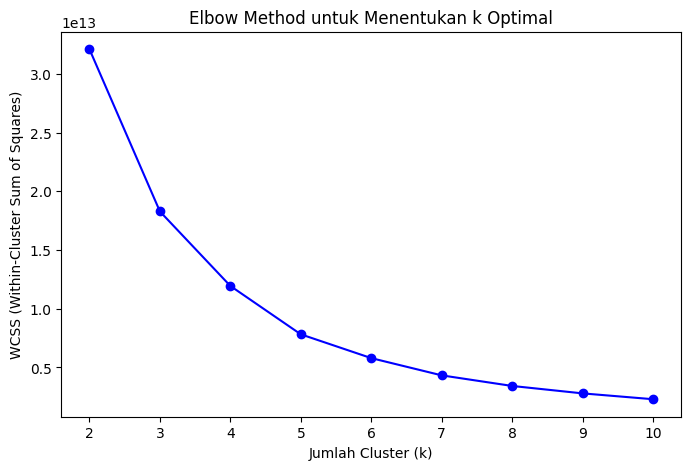

In [21]:
# --- CLUSTERING PREPARATION ---
# Pilih kolom numerik yang relevan untuk clustering
clustering_features = [
    'Duration',
    'Total Stops',
    'Price',
    'Airline',
    'Class',
    'Departure_Time',
    'Arrival_Time',
    'Departure_Place_Encoded',
    'Arrival_Place_Encoded',
    'Flight_Code_Encoded'
]
data_cluster = data[clustering_features].copy()

# --- ELBOW METHOD & SILHOUETTE SCORE (tanpa visualisasi silhouette) ---
from sklearn.metrics import silhouette_score
wcss = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_cluster)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(data_cluster, labels, sample_size=10000 if len(data_cluster) > 10000 else None, random_state=42)
    silhouette_scores.append(score)
    print(f'k={k}, silhouette_score={score:.4f}')

plt.figure(figsize=(8,5))
plt.plot(list(K), wcss, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.show()

In [22]:
# Train KMeans dengan k=2 dan tambahkan label cluster ke data
data_cluster = data[clustering_features].copy()
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
data['cluster_label'] = kmeans_final.fit_predict(data_cluster)
data['cluster_label'].value_counts()

cluster_label
0    327260
1    118106
Name: count, dtype: int64

In [23]:
data

,Date of Booking,Date of Journey,Duration,Total Stops,Price,Airline,Class,Flight_Code_Encoded,Departure_Time,Arrival_Time,Departure_Place_Encoded,Arrival_Place_Encoded,cluster_label
0,2023-01-15,2023-01-16,125,0,5335.0,7,1,836,1200,1325,3,6,0
1,2023-01-15,2023-01-16,140,0,5899.0,6,1,110,1380,80,3,6,0
2,2023-01-15,2023-01-16,130,0,5801.0,4,3,637,1350,40,3,6,0
3,2023-01-15,2023-01-16,125,0,5794.0,7,1,850,1130,1255,3,6,0
4,2023-01-15,2023-01-16,130,0,5955.0,0,1,606,1200,1330,3,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445361,2023-01-15,2023-03-06,675,1,61302.0,9,0,980,305,980,0,2,1
445362,2023-01-15,2023-03-06,670,1,65028.0,9,0,996,520,1190,0,2,1
445363,2023-01-15,2023-03-06,785,1,65028.0,9,0,982,405,1190,0,2,1
445364,2023-01-15,2023-03-06,675,1,69254.0,9,0,980,305,980,0,2,1


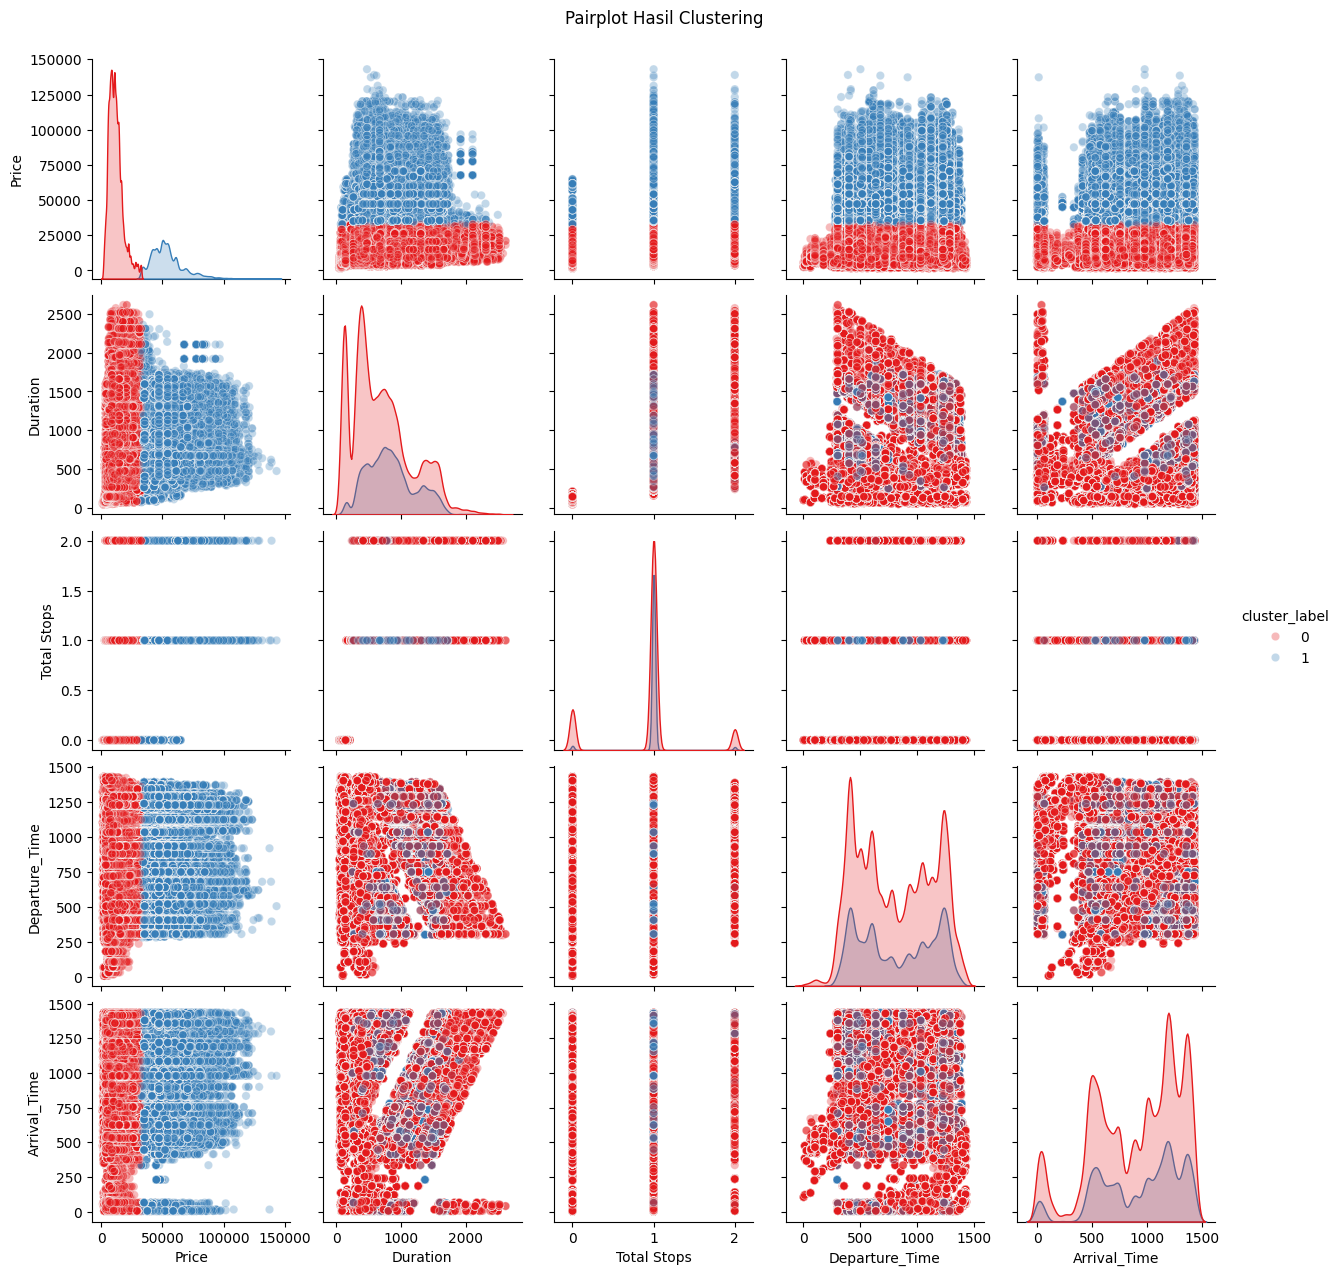

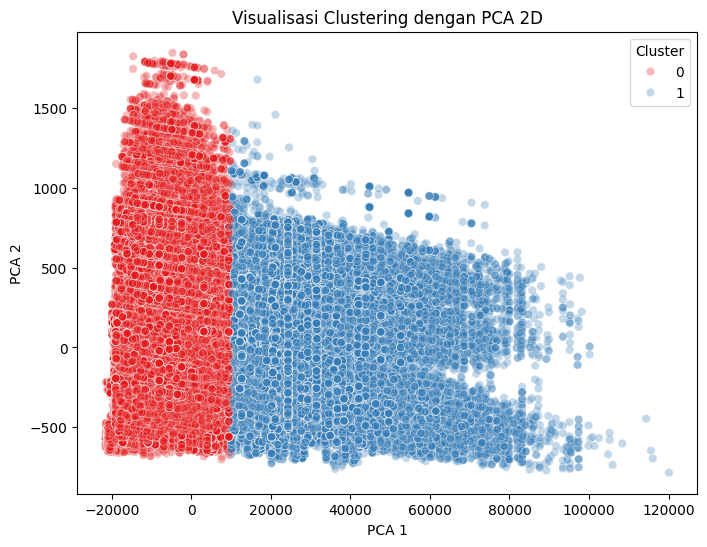

In [24]:
# Pilih beberapa fitur utama untuk pairplot
pairplot_features = ['Price', 'Duration', 'Total Stops', 'Departure_Time', 'Arrival_Time', 'cluster_label']
sns.pairplot(data[pairplot_features], hue='cluster_label', palette='Set1', plot_kws={'alpha':0.3})
plt.suptitle('Pairplot Hasil Clustering', y=1.02)
plt.show()

# Visualisasi PCA 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[clustering_features])
data['pca1'] = pca_result[:,0]
data['pca2'] = pca_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster_label', data=data, palette='Set1', alpha=0.3)
plt.title('Visualisasi Clustering dengan PCA 2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [25]:
data = data.drop(columns=['pca1', 'pca2'])

In [26]:
data

,Date of Booking,Date of Journey,Duration,Total Stops,Price,Airline,Class,Flight_Code_Encoded,Departure_Time,Arrival_Time,Departure_Place_Encoded,Arrival_Place_Encoded,cluster_label
0,2023-01-15,2023-01-16,125,0,5335.0,7,1,836,1200,1325,3,6,0
1,2023-01-15,2023-01-16,140,0,5899.0,6,1,110,1380,80,3,6,0
2,2023-01-15,2023-01-16,130,0,5801.0,4,3,637,1350,40,3,6,0
3,2023-01-15,2023-01-16,125,0,5794.0,7,1,850,1130,1255,3,6,0
4,2023-01-15,2023-01-16,130,0,5955.0,0,1,606,1200,1330,3,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445361,2023-01-15,2023-03-06,675,1,61302.0,9,0,980,305,980,0,2,1
445362,2023-01-15,2023-03-06,670,1,65028.0,9,0,996,520,1190,0,2,1
445363,2023-01-15,2023-03-06,785,1,65028.0,9,0,982,405,1190,0,2,1
445364,2023-01-15,2023-03-06,675,1,69254.0,9,0,980,305,980,0,2,1


In [27]:
print("INFORMASI DATA")
print(data.info())
print("=="*50)
print("DESKRIPSI DATA")
print(data.describe())  
print("=="*50)
print("DATA KOSONG")
print(data.isnull().sum())
print("=="*50)
print("DATA DUPLIKAT")
print(data.duplicated().sum())

INFORMASI DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445366 entries, 0 to 445365
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Date of Booking          445366 non-null  datetime64[ns]
 1   Date of Journey          445366 non-null  datetime64[ns]
 2   Duration                 445366 non-null  int64         
 3   Total Stops              445366 non-null  int64         
 4   Price                    445366 non-null  float64       
 5   Airline                  445366 non-null  int32         
 6   Class                    445366 non-null  int32         
 7   Flight_Code_Encoded      445366 non-null  int32         
 8   Departure_Time           445366 non-null  int64         
 9   Arrival_Time             445366 non-null  int64         
 10  Departure_Place_Encoded  445366 non-null  int32         
 11  Arrival_Place_Encoded    445366 non-null  int32         
 12  c

In [28]:
data

,Date of Booking,Date of Journey,Duration,Total Stops,Price,Airline,Class,Flight_Code_Encoded,Departure_Time,Arrival_Time,Departure_Place_Encoded,Arrival_Place_Encoded,cluster_label
0,2023-01-15,2023-01-16,125,0,5335.0,7,1,836,1200,1325,3,6,0
1,2023-01-15,2023-01-16,140,0,5899.0,6,1,110,1380,80,3,6,0
2,2023-01-15,2023-01-16,130,0,5801.0,4,3,637,1350,40,3,6,0
3,2023-01-15,2023-01-16,125,0,5794.0,7,1,850,1130,1255,3,6,0
4,2023-01-15,2023-01-16,130,0,5955.0,0,1,606,1200,1330,3,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445361,2023-01-15,2023-03-06,675,1,61302.0,9,0,980,305,980,0,2,1
445362,2023-01-15,2023-03-06,670,1,65028.0,9,0,996,520,1190,0,2,1
445363,2023-01-15,2023-03-06,785,1,65028.0,9,0,982,405,1190,0,2,1
445364,2023-01-15,2023-03-06,675,1,69254.0,9,0,980,305,980,0,2,1


## Prediksi Harga (Price) dengan Time Series
Kita akan menggunakan model time series sederhana (ARIMA) untuk memprediksi harga tiket berdasarkan tanggal pemesanan (Date of Booking) dan cluster hasil clustering.

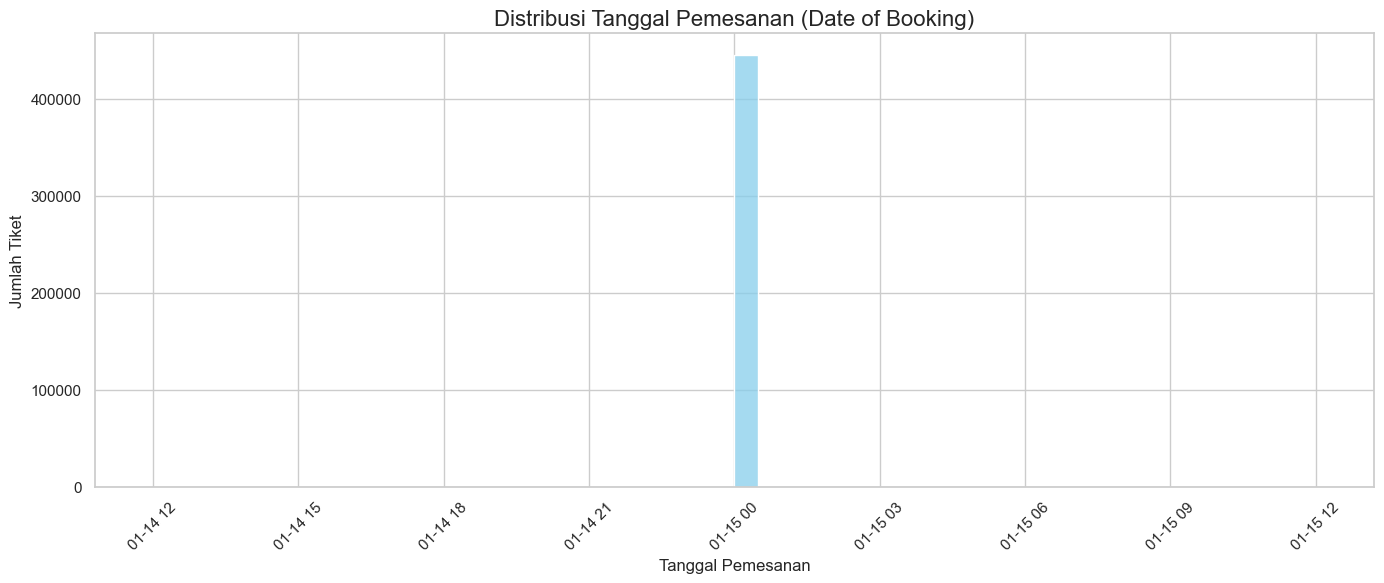

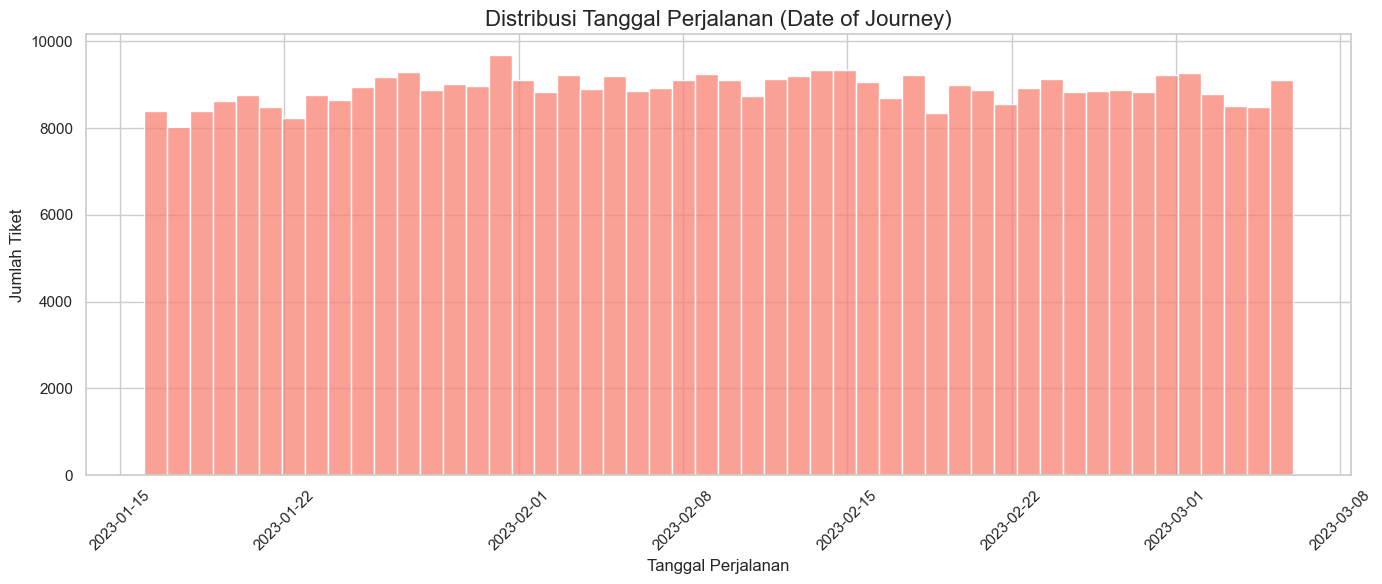

In [29]:
#Set style
sns.set(style='whitegrid')

# Plot distribusi jumlah pemesanan per hari
plt.figure(figsize=(14, 6))
sns.histplot(data['Date of Booking'], bins=50, kde=False, color='skyblue')
plt.title('Distribusi Tanggal Pemesanan (Date of Booking)', fontsize=16)
plt.xlabel('Tanggal Pemesanan')
plt.ylabel('Jumlah Tiket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot distribusi tanggal perjalanan
plt.figure(figsize=(14, 6))
sns.histplot(data['Date of Journey'], bins=50, kde=False, color='salmon')
plt.title('Distribusi Tanggal Perjalanan (Date of Journey)', fontsize=16)
plt.xlabel('Tanggal Perjalanan')
plt.ylabel('Jumlah Tiket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

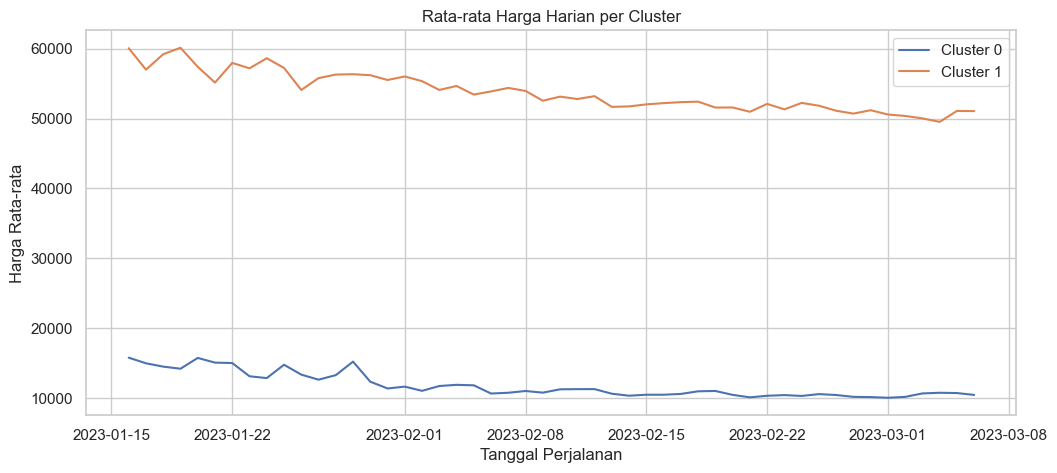

In [36]:
# Pastikan data sudah diurutkan berdasarkan tanggal
data = data.sort_values('Date of Journey').reset_index(drop=True)

clusters_to_plot = [0, 1]  # Cluster yang ingin divisualisasi

plt.figure(figsize=(12, 5))

for cluster_id in clusters_to_plot:
    data_ts = data[data['cluster_label'] == cluster_id].copy()
    data_ts = data_ts.sort_values('Date of Journey')
    
    # Group by tanggal, ambil rata-rata harga per hari
    price_daily = data_ts.groupby('Date of Journey')['Price'].mean().asfreq('D')
    
    # Isi missing value dengan interpolasi
    price_daily = price_daily.interpolate(method='linear')
    
    # Plot harga harian tiap cluster
    plt.plot(price_daily.index, price_daily.values, label=f'Cluster {cluster_id}')

plt.title('Rata-rata Harga Harian per Cluster')
plt.xlabel('Tanggal Perjalanan')
plt.ylabel('Harga Rata-rata')
plt.legend()
plt.show()

## **ARIMA: Cek Stationer, Transformasi, Modeling, dan Evaluasi untuk Kedua Cluster****


=== Cek Stasioneritas Cluster 0 ===
ADF Statistic: -3.1425
p-value: 0.0236
Data sudah stasioner (p-value <= 0.05).

=== Cek Stasioneritas Cluster 1 ===
ADF Statistic: -2.1132
p-value: 0.2393
Data tidak stasioner (p-value > 0.05). Lakukan differencing.


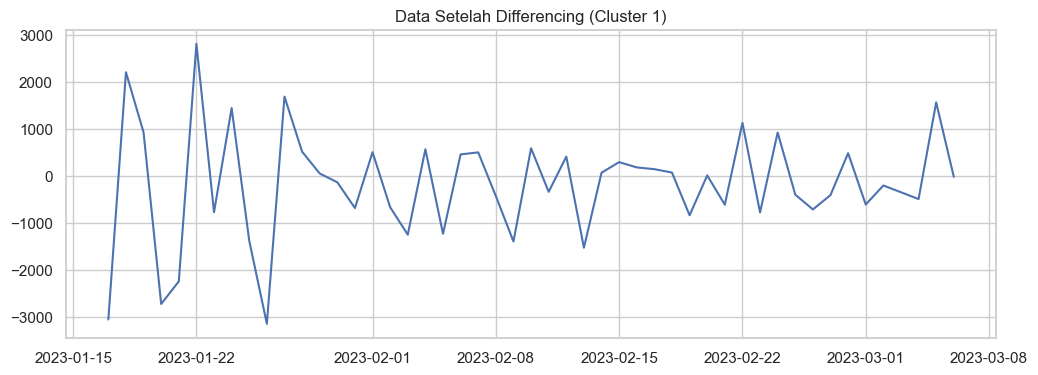

In [39]:
from statsmodels.tsa.stattools import adfuller

for cluster_id in [0, 1]:
    data_ts = data[data['cluster_label'] == cluster_id].copy()
    data_ts = data_ts.sort_values('Date of Journey')
    price_daily = data_ts.groupby('Date of Journey')['Price'].mean().asfreq('D')
    price_daily = price_daily.interpolate(method='linear')

    print(f"\n=== Cek Stasioneritas Cluster {cluster_id} ===")
    adf_result = adfuller(price_daily.dropna())
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    if adf_result[1] > 0.05:
        print("Data tidak stasioner (p-value > 0.05). Lakukan differencing.")
        # Plot data setelah differencing
        diff = price_daily.diff().dropna()
        plt.figure(figsize=(12,4))
        plt.plot(diff)
        plt.title(f'Data Setelah Differencing (Cluster {cluster_id})')
        plt.show()
    else:
        print("Data sudah stasioner (p-value <= 0.05).")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=797.230, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=796.964, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=794.655, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=796.144, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=793.249, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=792.465, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=792.317, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=790.969, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=796.144, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=793.249, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=792.465, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=792.317, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=790.969, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=791.429, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -390.411
Date:                Wed, 21 May 2025   AIC                            790.821
Time:                        15:42:30   BIC                            800.280
Sample:                    01-16-2023   HQIC                           794.410
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2418      0.103     -2.339      0.019      -0.444      -0.039
ar.L2         -0.2259      0.093     -2.433      0.015      -0.408      -0.044
ar.L3         -0.0934      0.098     -0.949      0.342      -0.286       0.099
ar.L4          0.1406      0.090      1.555      0.120      -0.037       0.318
sigma2      4.928e+05   8.89e+04      5.544      0.000    3.19e+05    6.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 5.94
Prob(Q):                              0.76   Prob(JB):                         0.05
Heteroskedasticity (H):               0.06   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

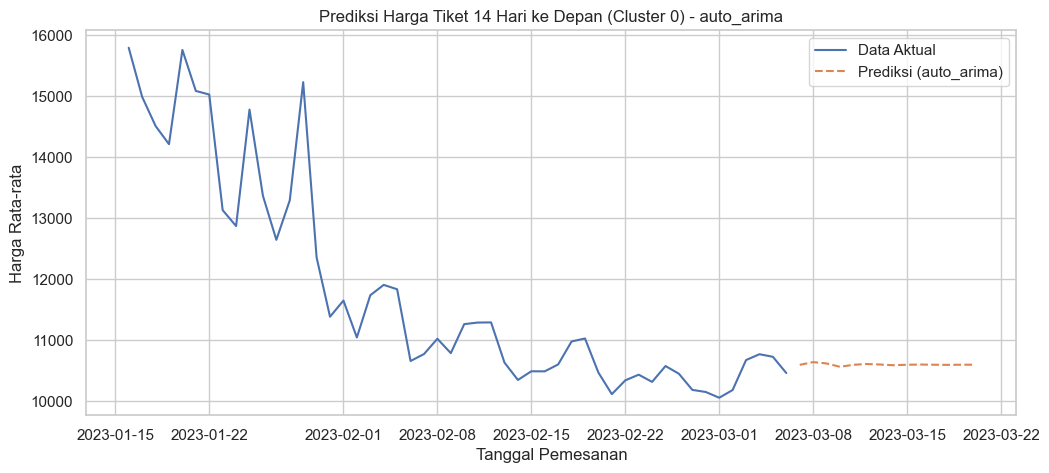

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=825.021, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=837.454, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=830.637, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=836.576, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=836.601, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=813.840, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=833.368, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=813.840, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=833.368, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=841.807, Time=0.13 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -399.920
Date:                Wed, 21 May 2025   AIC                            813.840
Time:                        15:42:31   BIC                            827.083
Sample:                    01-16-2023   HQIC                           818.865
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -428.8280    215.644     -1.989      0.047    -851.483      -6.173
ar.L1          0.3539      0.107      3.318      0.001       0.145       0.563
ar.L2         -0.7252      0.094     -7.722      0.000      -0.909      -0.541
ar.L3         -0.1066      0.073     -1.464      0.143      -0.249       0.036
ma.L1         -0.4689      0.076     -6.145      0.000      -0.618      -0.319
ma.L2          0.9231      0.112      8.219      0.000       0.703       1.143
sigma2      7.639e+05   1.91e+05      3.993      0.000    3.89e+05    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.80   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.01   Prob(JB):                         0.46
Heteroskedasticity (H):               0.45   Skew:                            -0.22
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

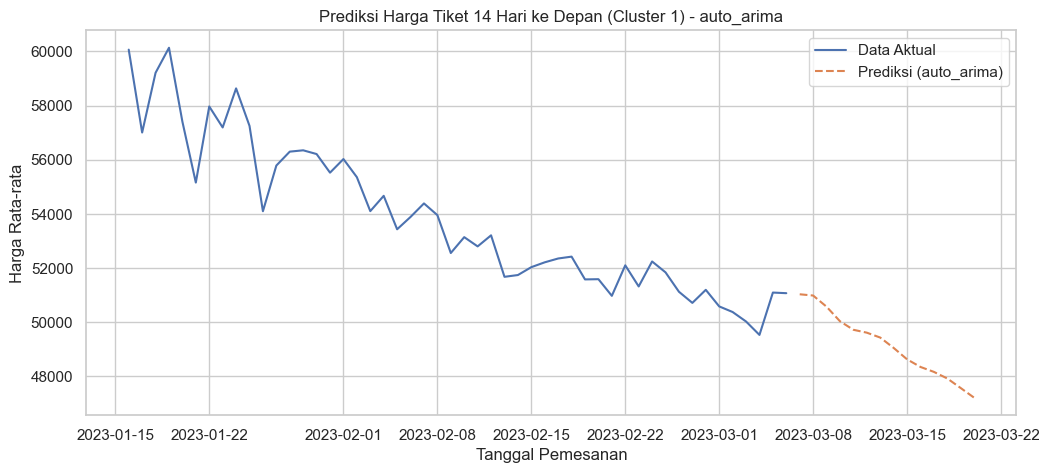

In [40]:
# --- Prediksi Harga Tiket dengan auto_arima (pmdarima) untuk Kedua Cluster ---
from pmdarima import auto_arima

for auto_cluster_id in [0, 1]:
    data_ts_auto = data[data['cluster_label'] == auto_cluster_id].copy()
    data_ts_auto = data_ts_auto.sort_values('Date of Journey')

    # Group by tanggal, ambil rata-rata harga per hari
    price_daily_auto = data_ts_auto.groupby('Date of Journey')['Price'].mean().asfreq('D')
    price_daily_auto = price_daily_auto.interpolate(method='linear')

    # Train auto_arima
    model_auto = auto_arima(price_daily_auto, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

    # Ringkasan model
    display(model_auto.summary())

    # Prediksi 14 hari ke depan
    n_forecast = 14
    forecast_auto = model_auto.predict(n_periods=n_forecast)

    # Plot hasil prediksi
    plt.figure(figsize=(12,5))
    plt.plot(price_daily_auto.index, price_daily_auto.values, label='Data Aktual')
    plt.plot(pd.date_range(price_daily_auto.index[-1], periods=n_forecast+1, freq='D')[1:], forecast_auto, label='Prediksi (auto_arima)', linestyle='--')
    plt.title(f'Prediksi Harga Tiket 14 Hari ke Depan (Cluster {auto_cluster_id}) - auto_arima')
    plt.xlabel('Tanggal Pemesanan')
    plt.ylabel('Harga Rata-rata')
    plt.legend()
    plt.show()


=== Evaluasi Cluster 0 (auto_arima) ===
MAE (in-sample): 790.24
RMSE (in-sample): 2337.57


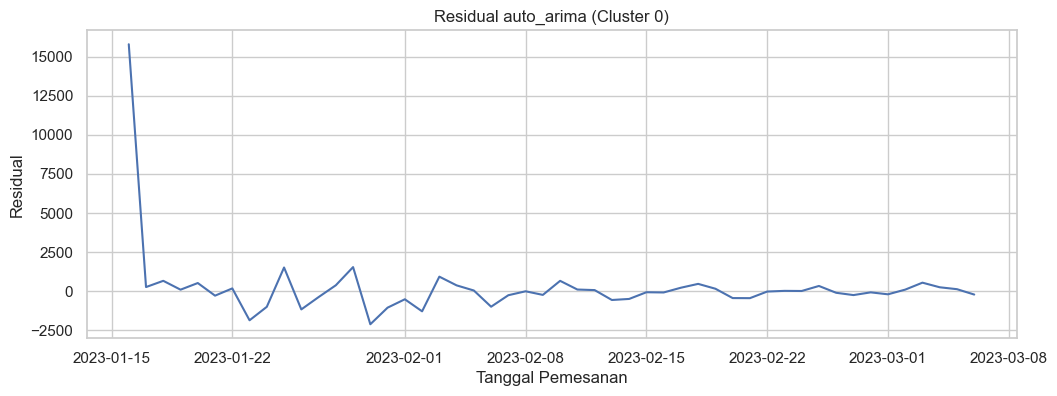

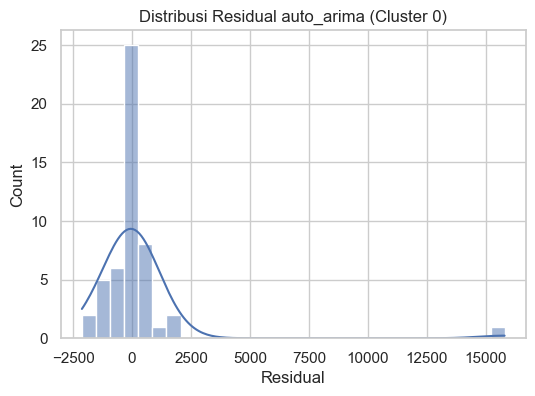


=== Evaluasi Cluster 1 (auto_arima) ===
MAE (in-sample): 1857.60
RMSE (in-sample): 8576.54


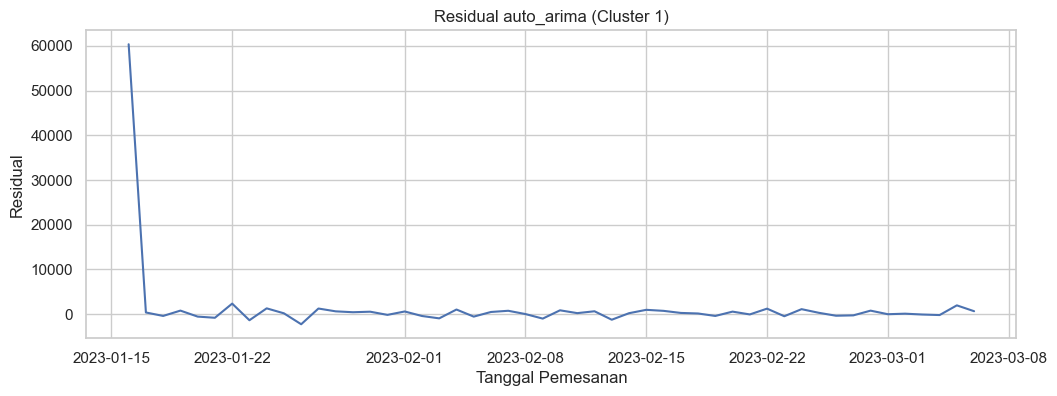

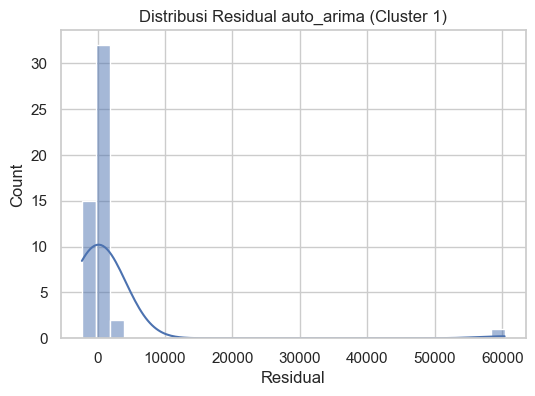

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

for auto_cluster_id in [0, 1]:
    data_ts_auto = data[data['cluster_label'] == auto_cluster_id].copy()
    data_ts_auto = data_ts_auto.sort_values('Date of Journey')

    # Group by tanggal, ambil rata-rata harga per hari
    price_daily_auto = data_ts_auto.groupby('Date of Journey')['Price'].mean().asfreq('D')
    price_daily_auto = price_daily_auto.interpolate(method='linear')

    # Train auto_arima
    model_auto = auto_arima(price_daily_auto, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)

    # In-sample prediction (fitted values)
    fitted_auto = model_auto.predict_in_sample()
    y_true_auto = price_daily_auto.values
    fitted_auto = fitted_auto[-len(y_true_auto):]  # align if needed

    mae_auto = mean_absolute_error(y_true_auto, fitted_auto)
    rmse_auto = np.sqrt(mean_squared_error(y_true_auto, fitted_auto))
    print(f"\n=== Evaluasi Cluster {auto_cluster_id} (auto_arima) ===")
    print(f"MAE (in-sample): {mae_auto:.2f}")
    print(f"RMSE (in-sample): {rmse_auto:.2f}")

    # Plot residual
    residuals_auto = y_true_auto - fitted_auto
    plt.figure(figsize=(12,4))
    plt.plot(price_daily_auto.index, residuals_auto)
    plt.title(f'Residual auto_arima (Cluster {auto_cluster_id})')
    plt.xlabel('Tanggal Pemesanan')
    plt.ylabel('Residual')
    plt.show()

    # Plot distribusi residual
    plt.figure(figsize=(6,4))
    sns.histplot(residuals_auto, kde=True, bins=30)
    plt.title(f'Distribusi Residual auto_arima (Cluster {auto_cluster_id})')
    plt.xlabel('Residual')
    plt.show()

## **ARIMAX: Cek Stationer, Transformasi, Modeling, dan Evaluasi untuk Kedua Cluster**


=== ARIMAX untuk Cluster 0 ===
ADF Statistic: -3.142484
p-value: 0.023565
Critical Value (1%): -3.606
Critical Value (5%): -2.937
Critical Value (10%): -2.607
Data sudah stationer


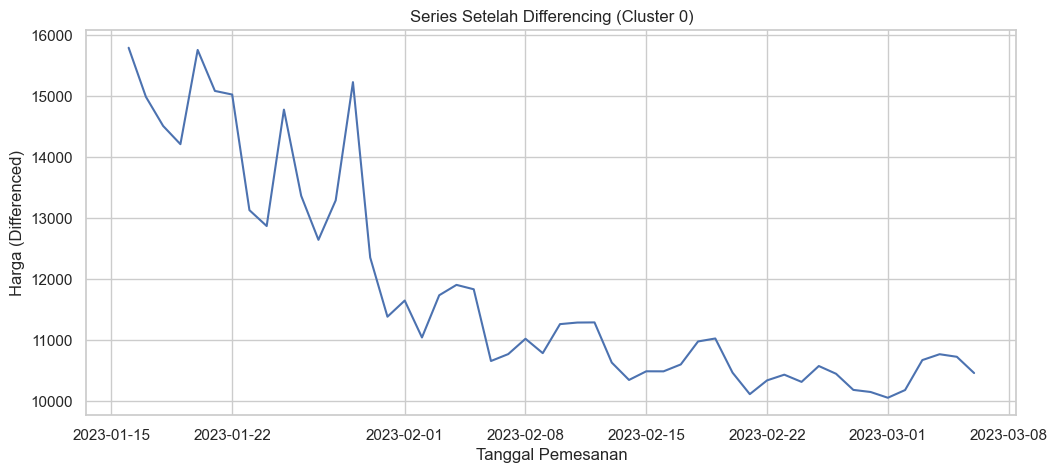

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                   50
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -373.433
Date:                Wed, 21 May 2025   AIC                            756.865
Time:                        15:55:16   BIC                            766.221
Sample:                    01-16-2023   HQIC                           760.401
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Duration       70.6643      7.108      9.942      0.000      56.733      84.595
Total Stops -4.032e+04   5242.109     -7.692      0.000   -5.06e+04      -3e+04
ar.L1           0.7229      0.126      5.752    

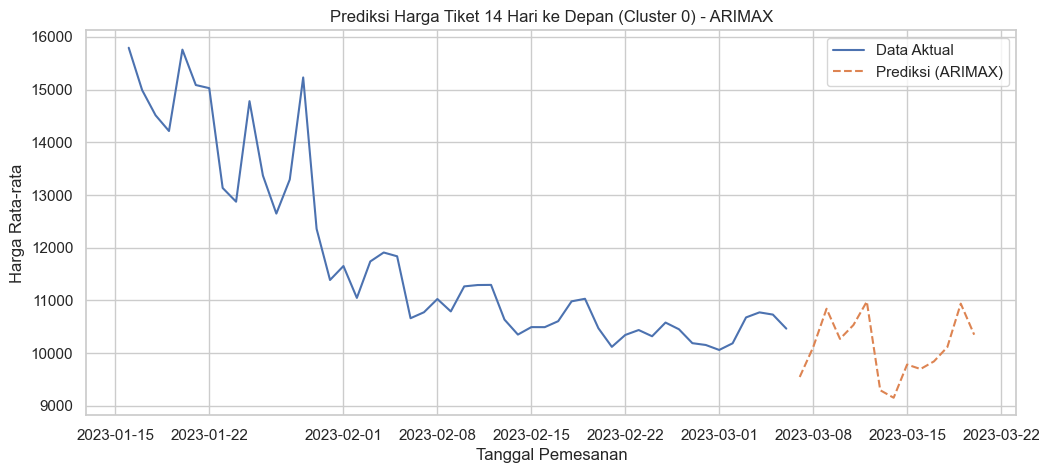

MAE (in-sample): 523.15
RMSE (in-sample): 765.87


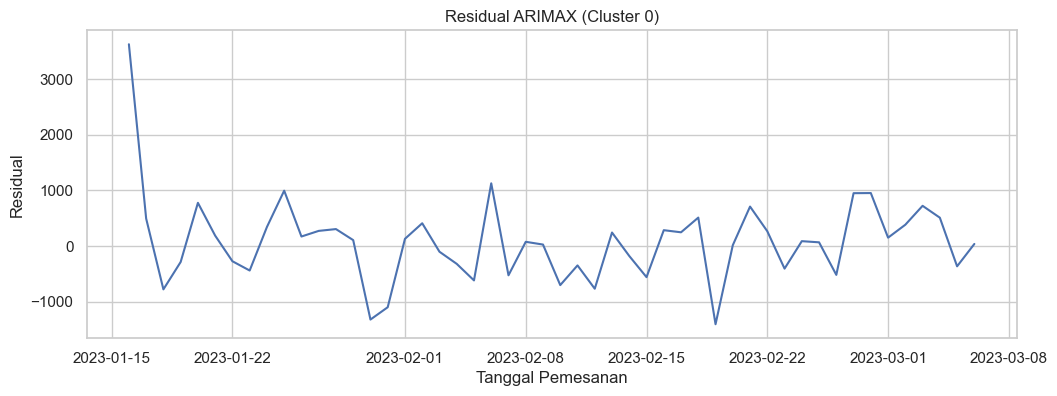

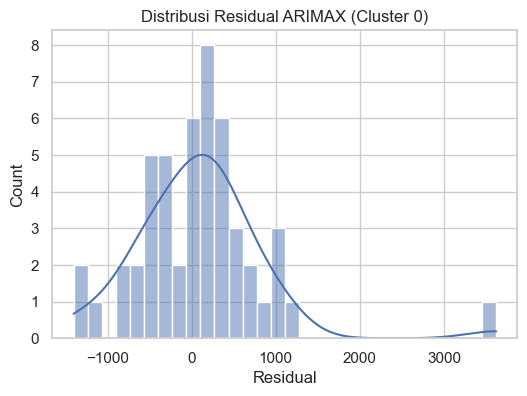


=== ARIMAX untuk Cluster 1 ===
ADF Statistic: -2.113150
p-value: 0.239260
Critical Value (1%): -3.597
Critical Value (5%): -2.933
Critical Value (10%): -2.605
Data belum stationer, lakukan differencing


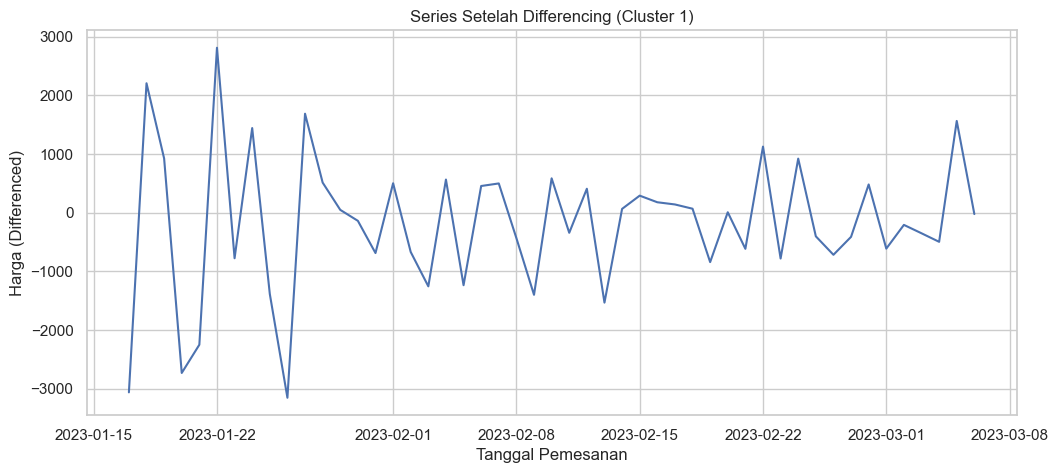

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                   50
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -383.504
Date:                Wed, 21 May 2025   AIC                            777.008
Time:                        15:55:17   BIC                            786.259
Sample:                    01-16-2023   HQIC                           780.490
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Duration       22.7680     22.418      1.016      0.310     -21.170      66.706
Total Stops -1.072e+05   4.26e+04     -2.519      0.012   -1.91e+05   -2.38e+04
ar.L1           0.0818      0.206      0.397    

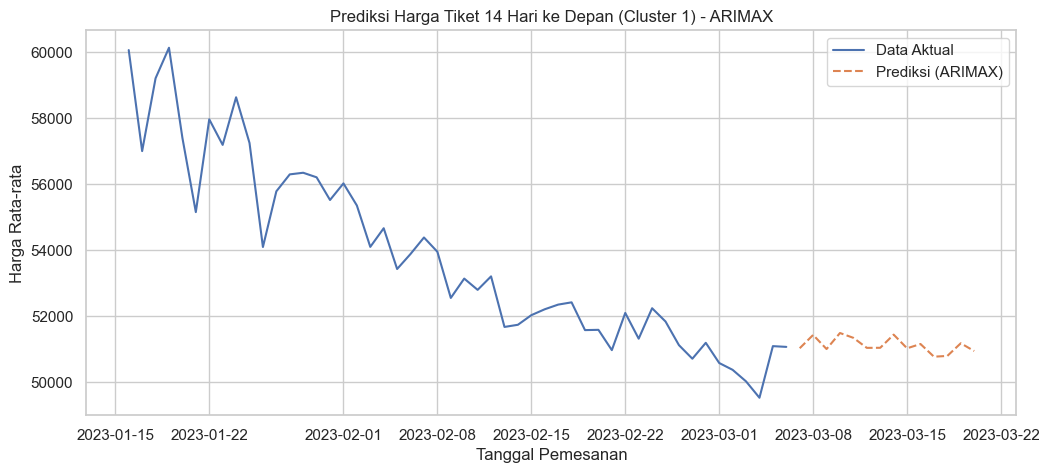

MAE (in-sample): 3636.59
RMSE (in-sample): 20812.57


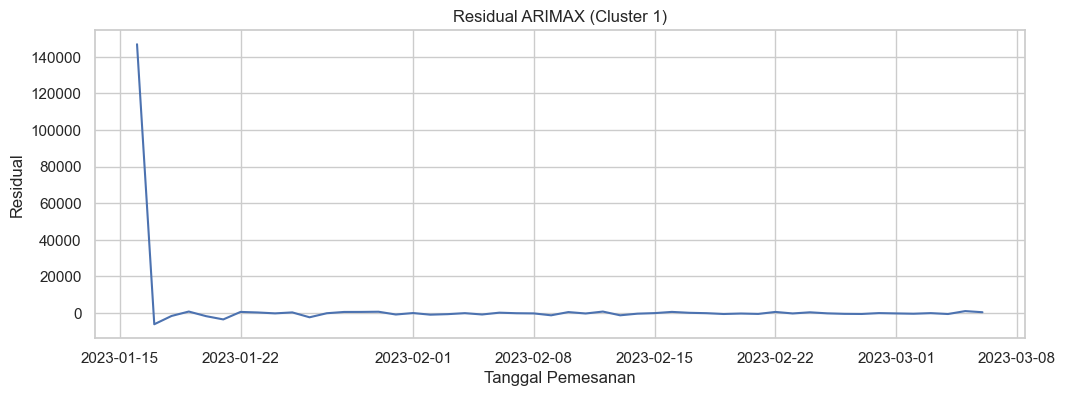

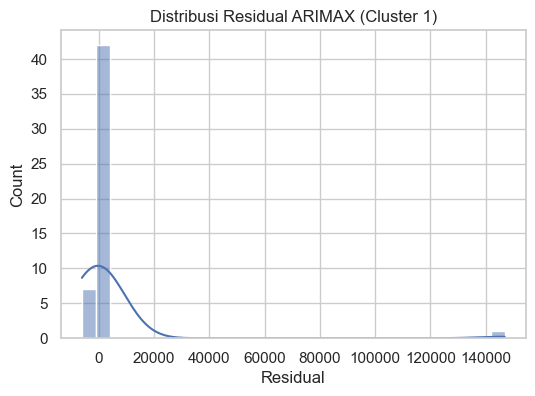

In [43]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

for arimax_cluster_id in [0, 1]:
    print(f"\n=== ARIMAX untuk Cluster {arimax_cluster_id} ===")
    data_arimax = data[data['cluster_label'] == arimax_cluster_id].copy()
    data_arimax = data_arimax.sort_values('Date of Journey')

    # Group by tanggal, ambil rata-rata harga per hari dan fitur exogenous
    price_daily = data_arimax.groupby('Date of Journey')['Price'].mean().asfreq('D')
    exog_daily = data_arimax.groupby('Date of Journey')[['Duration', 'Total Stops']].mean().asfreq('D')

    # Interpolasi missing value
    price_daily = price_daily.interpolate(method='linear')
    exog_daily = exog_daily.interpolate(method='linear')

    # --- Cek Stationer dengan ADF Test ---
    result = adfuller(price_daily.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
    if result[1] < 0.05:
        print('Data sudah stationer')
        price_stationer = price_daily
        exog_stationer = exog_daily
        d = 0
    else:
        print('Data belum stationer, lakukan differencing')
        price_stationer = price_daily.diff().dropna()
        exog_stationer = exog_daily.loc[price_stationer.index]
        d = 1

    # --- Plot hasil differencing ---
    plt.figure(figsize=(12,5))
    plt.plot(price_stationer.index, price_stationer.values)
    plt.title(f'Series Setelah Differencing (Cluster {arimax_cluster_id})')
    plt.xlabel('Tanggal Pemesanan')
    plt.ylabel('Harga (Differenced)')
    plt.show()

    # --- Modeling ARIMAX ---
    order = (1, d, 1)
    model_arimax = sm.tsa.SARIMAX(price_daily, order=order, exog=exog_daily, enforce_stationarity=False, enforce_invertibility=False)
    model_arimax_fit = model_arimax.fit(disp=False)
    print(model_arimax_fit.summary())

    # --- Prediksi 14 hari ke depan ---
    # Untuk prediksi, gunakan exog dari 14 hari terakhir (atau bisa juga exog masa depan jika tersedia)
    future_exog = exog_daily.iloc[-14:]
    forecast_arimax = model_arimax_fit.forecast(steps=14, exog=future_exog)

    # --- Plot hasil prediksi ---
    plt.figure(figsize=(12,5))
    plt.plot(price_daily.index, price_daily.values, label='Data Aktual')
    plt.plot(pd.date_range(price_daily.index[-1], periods=15, freq='D')[1:], forecast_arimax, label='Prediksi (ARIMAX)', linestyle='--')
    plt.title(f'Prediksi Harga Tiket 14 Hari ke Depan (Cluster {arimax_cluster_id}) - ARIMAX')
    plt.xlabel('Tanggal Pemesanan')
    plt.ylabel('Harga Rata-rata')
    plt.legend()
    plt.show()

    # --- Evaluasi In-sample (Fitted) ---
    fitted_arimax = model_arimax_fit.fittedvalues
    y_true = price_daily.values
    y_pred = fitted_arimax.values[-len(y_true):]  # align if needed
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"MAE (in-sample): {mae:.2f}")
    print(f"RMSE (in-sample): {rmse:.2f}")

    # Plot residual
    residuals = y_true - y_pred
    plt.figure(figsize=(12,4))
    plt.plot(price_daily.index, residuals)
    plt.title(f'Residual ARIMAX (Cluster {arimax_cluster_id})')
    plt.xlabel('Tanggal Pemesanan')
    plt.ylabel('Residual')
    plt.show()

    # Plot distribusi residual
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'Distribusi Residual ARIMAX (Cluster {arimax_cluster_id})')
    plt.xlabel('Residual')
    plt.show()